# Get Data 

In [8]:
import pandas as pd
import math 
import os
import numpy as np

data_type = 'word'
sample = 'all'


if data_type == 'word':
    labels_count = 2
else:
    labels_count = 10 

def generate_data(data_type, testing_subjects):
    '''
    returns a training test split based on files read from directory 
    :param data_type: pass either 'word' or 'num'
    :param training_subjects: number of training subjects 2 or greater
    :return: returns a traning and test dataframe 
    '''
    testing = []
    data_final = []
    main_dir = os.listdir('data/subjects/') 
    steps = 1
    for direc in main_dir: 
        if data_type in direc:
            main_file = os.listdir('data/subjects/'+ direc)
            for file in main_file:
                if 'final' in file:
                    data = pd.read_csv('data/subjects/'+ direc+'/'+file)
                    if steps <= testing_subjects: 
                        testing.append(data)
                    else: 
                        data_final.append(data)
            steps += 1
    data_training = pd.concat(data_final, ignore_index = True)
    data_training.dropna(inplace=True)
    data_training.reset_index(inplace = True, drop = True)
    
    data_testing= pd.concat(testing, ignore_index = True)
    data_testing.dropna(inplace=True)
    data_testing.reset_index(inplace = True, drop = True)
    return data_training, data_testing


if sample != 'all':
    training = pd.read_csv('data/subjects/'+ sample +'/'+sample+'_final.csv')
else:
    training, testing = generate_data(data_type, 2)

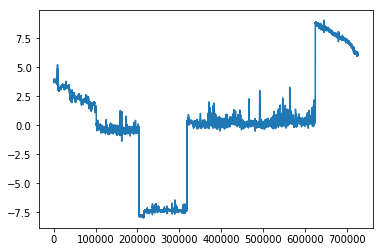

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Right Jaw 
plt.plot('CH_1_mV', data = training)
plt.show()

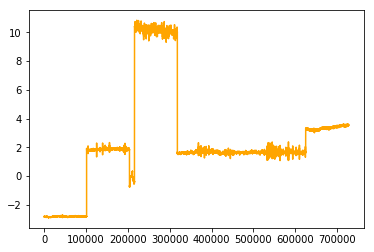

In [10]:
# Left Cheeck
plt.plot('CH_2_mV', data= training,  color='orange')
plt.show()

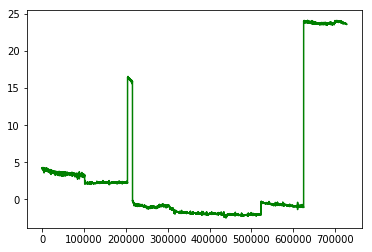

In [11]:
# Throat
plt.plot('CH_3_mV', data= training,  color='green')
plt.show()

# Clean Data 

In [12]:
# add Low pass filter 

def low_pass(fc, b):
    '''
    :param fc: cutoff frequency
    :param b: bandwidth
    :return: low pass filter
    '''
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    #window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    window = np.blackman(N)
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)
    return sinc_func

# look up time-domain vs frequency domain relationship 

In [13]:
# add high

def high_pass(fc, b):
    '''
    :param fc: cutoff frequency
    :param b: bandwidth
    :return: high pass filter
    '''
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = np.blackman(N)
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    # reverse function
    sinc_func = -sinc_func
    sinc_func[int((N - 1) / 2)] += 1
    return sinc_func

# look up time-domain vs frequency domain relationship 

In [14]:


print('original len: ', len(training['CH_2_mV']))

lp_filter = low_pass(0.02,0.08)
lp_signal = np.convolve(training['CH_1_mV'], lp_filter)
lp_signal = pd.DataFrame({'CH_1_mV': lp_signal})

diff = len(lp_signal)- len(training)
del_rows = diff/2
ouput = lp_signal.loc[del_rows:len(lp_signal)-del_rows-1]
lp_signal.dropna(inplace=True)
lp_signal.reset_index(inplace = True, drop = True)


print('lp len: ', len(lp_signal))

hp_filter = high_pass(0.001,0.01)
hp_signal = np.convolve(lp_signal['CH_1_mV'], hp_filter)
hp_signal = pd.DataFrame({'CH_1_mV': hp_signal})
print('hp_len: ', len(lp_signal))

original len:  727506
lp len:  727556
hp_len:  727556


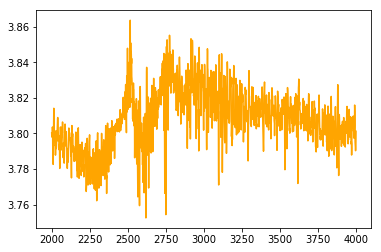

In [15]:
# Left Cheeck
plt.plot('CH_1_mV', data= training[2000:4000],  color='orange')
plt.show()

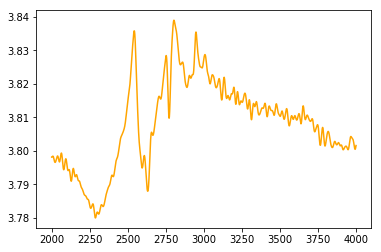

In [16]:
# Left Cheeck
plt.plot('CH_1_mV', data = lp_signal[2000:4000],  color='orange')
plt.show()

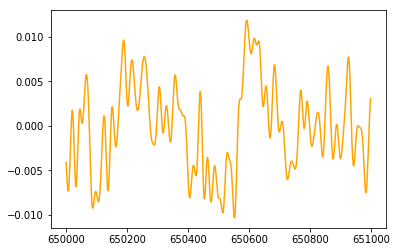

In [17]:
# Left Cheeck
plt.plot('CH_1_mV', data = hp_signal[650000:651000],  color='orange')
plt.show()

In [18]:
# Create new dataframe after filtering data 

def low_pass_data(fc,bw, data):
    lp_filter = low_pass(fc,bw)
    hp_filter = high_pass(0.001,0.01)
    cln= {'CH_1_mV': np.convolve(np.convolve(data['CH_1_mV'], lp_filter),hp_filter), 
          'CH_2_mV': np.convolve(np.convolve(data['CH_1_mV'], lp_filter),hp_filter),
          'CH_3_mV': np.convolve(np.convolve(data['CH_1_mV'], lp_filter),hp_filter)}
    output = pd.DataFrame(cln)
    diff = len(output)- len(data)
    del_rows = diff/2
    ouput = output.loc[del_rows:len(output)-del_rows-1]
    output.dropna(inplace=True)
    output.reset_index(inplace = True, drop = True)
    output['Target'] = data['Target']
    return output 

def round_up_to_even(f):
    return math.ceil(f / 2.) * 2

filtered_training = low_pass_data(0.02,0.08,training)
filtered_testing = low_pass_data(0.02, 0.08, testing)


In [19]:
filtered_testing['Target'].unique()

array(['relax', 'yes', 'no', nan], dtype=object)

In [20]:
# deterime value ranges for targets 
import more_itertools as mit

def min_max(data, val ='targets'):
    if val == 'targets':
         values = data[data['Target'] != 'relax'].index.tolist()
    else:
         values = data[data['Target'] == 'relax'].index.tolist()
    groups = [list(group) for group in mit.consecutive_groups(values)]
    return groups

groups_targets = min_max(filtered_training,'targets')
groups_non = min_max(filtered_training,val = 'non')
groups_train = groups_targets

groups_targets_test = min_max(filtered_testing,'targets')
groups_non_test = min_max(filtered_testing,val = 'non')
groups_test = groups_targets_test

# Visualize filtered data

In [21]:
 def create_plots(rows, data, item = 'all'):
    '''
    :param rows: rows from ranges of taget values 
    :param data: data frame to use
    :return: plot of signals
    '''
    if item == data.iloc[min(rows) + 10]['Target'] or item == 'all':
        
        plt.figure(figsize=(25,5))

        plt.subplot(1,4,1)
        plt.plot(data['CH_1_mV'][min(rows):max(rows)])

        plt.subplot(1,4,2)
        plt.plot(data['CH_2_mV'][min(rows):max(rows)])

        plt.subplot(1,4,3)
        plt.plot(data['CH_3_mV'][min(rows):max(rows)])

        plt.subplot(1,4,4)
        plt.text(0.35, 0.5, data.iloc[min(rows) + 10]['Target'] , dict(size=25))

        plt.show()

In [22]:
#Plot Results 
#for rows in groups_train:
#    create_plots(rows, filtered_training, 'no')

In [23]:
# Find average length of each signal

def max_len(groups):
    avg_len = [(max(val)-min(val)) for val in groups]
    avg = sum(avg_len)/len(avg_len)
    return avg

# Transform Data 

In [24]:
# Transform data with normaizliation 
def trans_data_train(df, val = 'z'):
    for col in df:
        if col not in ['Target']:
            if val == 'z':  
                #take the z-score 
                df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)
            else:
                #normaizize data between [0,1]
                df[col]=(df[col]-df[col].min())/(df[col].max()-df[col].min())
         
        
def trans_data_test(df_test, df_train, val ='z'):
    for col in df_test:
        if col not in ['Target']:
            if val == 'z':
                #take the z-score 
                df_test[col] = (df_test[col] - df_train[col].mean())/df_train[col].std(ddof=0)
            else:
                #normaizize data between [0,1]
                df_test[col]=(df_test[col]-df_test[col].min())/(df_test[col].max()-df_test[col].min())                                  
                
trans_data_train(filtered_training,'z')
trans_data_test(filtered_testing, filtered_training,'z')

In [213]:
# Transform Target column to intergers 

def new_cat_word(row):
    if row == 'relax':
        return 99
    if row == 'no':
        return 0
    else:
        return 1
    
def new_cat_num(row):
    if row == 'relax':
        return 99
    if row == '1':
        return 1
    if row == '2':
        return 2
    if row == '3':
        return 3
    if row == '4':
        return 4
    if row == '5':
        return 5
    if row == '6':
        return 6
    if row == '7':
        return 7
    if row == '8':
        return 8
    if row == '9':
        return 9
    if row == '0':
        return 0

def target_col(val='num'):
    if val == 'num':
        filtered_testing['Target'] = filtered_testing['Target'].apply(new_cat_num)
        filtered_training['Target'] = filtered_training['Target'].apply(new_cat_num)
    else:
        filtered_testing['Target'] = filtered_testing['Target'].apply(new_cat_word)
        filtered_training['Target'] = filtered_training['Target'].apply(new_cat_word)

        
target_col(data_type)

In [ ]:
#new_training = new_training.iloc[:,0:2]
X_train = [filtered_training[['CH_1_mV', 'CH_2_mV', 'CH_3_mV']].loc[min(val):max(val)].values for val in groups_train]
y_train = [int(filtered_training['Target'].loc[min(val):max(val)].unique()) for val in groups_train]
X_test = [filtered_testing[['CH_1_mV', 'CH_2_mV','CH_3_mV']].loc[min(val):max(val)].values for val in groups_test]
y_test = [int(filtered_testing['Target'].loc[min(val):max(val)].unique()) for val in groups_test]

# Shape Data

In [ ]:
from keras.preprocessing import sequence
import tensorflow as tf


max_length = round_up_to_even(max_len(groups))

X_train = sequence.pad_sequences(X_train, dtype ='float32', maxlen = max_length, padding = 'post', truncating = 'post')
#y_train = sequence.pad_sequences(y_train, dtype ='float32', maxlen = max_length, padding = 'post', truncating = 'post')
y_train = np.array(y_train)
X_test = sequence.pad_sequences(X_test, dtype ='float32', maxlen = max_length, padding = 'post', truncating = 'post')
#y_test = sequence.pad_sequences(y_test, dtype ='float32', maxlen = max_length, padding = 'post', truncating = 'post')
y_test = np.array(y_train)

In [ ]:
#for i in range(0,len(y_train)):
#    if len(y_train[i]) > 1:
#        y_train[i] = np.array([y_train[102][0]])
    

In [ ]:
from keras.utils import np_utils 
#Categorical One-Hot encoded values 

train_y = np_utils.to_categorical(y_train, labels_count)
test_y = np_utils.to_categorical(y_test, labels_count)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
train_y.shape

# Save Data 

In [ ]:
np.save('data/X_train', X_train)
np.save('data/X_test', X_test)
np.save('data/y_train', y_train)
np.save('data/y_test', y_test)
np.save('data/train_y', train_y)
np.save('data/test_y', test_y)
np.save('data/max', max_length)